In [5]:
import pandas as pd
import json
import glob 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime,timedelta,date
import dateutil.parser
import numpy as np

pd.set_option('display.max_rows', 4000)

In [4]:
def get_arrival_time(dataframe):
    arrival_time_list = []
    
    for i in range(len(dataframe)-1):
        if not(dataframe.iloc[i,1] == 0)  and (dataframe.iloc[i+1,1] == 0 )  :
           # list.append(dataframe1.iloc[j+i,5])
            arrival_time_list.append(dataframe.iloc[i+1,2])
        
    return arrival_time_list

In [5]:
from re import L
import pandas as pd
import datetime as dt
import datetime
from datetime import timedelta,timezone
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import dict_factory

auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
cluster = Cluster(contact_points=['158.132.175.131'], port='9042',
    auth_provider=auth_provider)

session = cluster.connect('hki_gmb')
session.row_factory = dict_factory

def convert_timezone(timestamp):
    return timestamp.tz_localize(tz = 'UTC').tz_convert(tz ='Asia/Hong_Kong')


def select_data(gen_date,route_id,route_seq,stop):

    # sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = {} and gen_date = '{}' and route_seq = {} and stop_seq = {} and fetch_moment >= '{}+0800' and gen_time <= fetch_monent  limit 40;".format(route_id,gen_date,route_seq,stop_seq, now_time )
    # sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = {} and gen_date = '{}' and route_seq = {} and stop_seq = {} and fetch_moment >= '{}+0800' ;".format(route_id,gen_date,route_seq,stop_seq, now_time )
    
    # sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = 2003472 and gen_date = '{}' and route_seq = 1 and stop_seq = {} and fetch_moment >= '{} 16:00:00+0800' and fetch_moment <= '{} 17:00+0800' ;".format(gen_date,stop,gen_date,gen_date)
    
    
    sql_query = "SELECT * FROM hki_gmb.route30_eta_data where route_id = {} and gen_date = '{}' and route_seq = {} and stop_seq = {} and fetch_moment >= '{} 04:30:00+0800' and fetch_moment <= '{} 00:30:00+0800' ;".format(route_id, gen_date,route_seq,stop,gen_date, str(datetime.datetime.strptime(gen_date, "%Y-%m-%d").date() + datetime.timedelta(days = 1)))
#    sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = {} and gen_date = '{}' and route_seq = {} and stop_seq = {}  ;".format(route_id, gen_date,route_seq,stop)



#     sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = 2003472 and gen_date = '{}' and route_seq = 1 and stop_seq = {} ;".format(gen_date,stop)


    # .format(route_id,gen_date,route_seq,stop_seq, now_time )
    # sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = {} and gen_date = '2022-08-10' and route_seq = {} and stop_seq = {}  ;".format(route_id,route_seq,stop_seq, now_time )


    # sql_query = "SELECT * FROM hki_gmb.eta_data where route_id = {} and gen_date = '{}' and route_seq = {} and stop_seq = {} ;".format(route_id,gen_date,route_seq,stop_seq)




    dictionary ={ "fetch_moment":[], "eta_1_diff":[], "eta_1_time":[],"eta_1_remark":[], "eta_2_diff":[], "eta_2_time":[],"eta_2_remark":[], "eta_3_diff":[], "eta_3_time":[],"eta_3_remark":[],"gen_time":[]}
    # "route_id" :[], "route_seq" :[], "stop_seq":[],



    for row in session.execute(sql_query):

        dictionary["fetch_moment"].append(row['fetch_moment'])
        dictionary["eta_1_diff"].append(row['eta_1_diff'])
        dictionary["eta_1_time"].append(row['eta_1_time'])
        dictionary["eta_1_remark"].append(row['eta_1_remark'])
        dictionary["eta_2_diff"].append(row['eta_2_diff'])
        dictionary["eta_2_time"].append(row['eta_2_time'])
        dictionary["eta_2_remark"].append(row['eta_2_remark'])
        dictionary["eta_3_diff"].append(row['eta_3_diff'])
        dictionary["eta_3_time"].append(row['eta_3_time'])
        dictionary["eta_3_remark"].append(row['eta_3_remark'])
        dictionary["gen_time"].append(row['gen_time'])

    df = pd.DataFrame(dictionary)


    df['fetch_moment'] = df['fetch_moment'].apply(convert_timezone)
    df['eta_1_time'] = df['eta_1_time'].apply(convert_timezone)
    df['eta_2_time'] = df['eta_2_time'].apply(convert_timezone)
    df['eta_3_time'] = df['eta_3_time'].apply(convert_timezone)
    df['gen_time'] = df['gen_time'].apply(convert_timezone)

    return df



In [8]:
# convert map infomation

GMB_route_map = pd.read_excel('MB_30_HV.xls',header=0)
GMB_route_map_length = (GMB_route_map.groupby(['stop_range']).sum()['Shape_Length']*100000)
GMB_route_map_length

stop_range
1    296.268940
2    730.956296
3    153.426923
4    169.584868
5    474.034992
Name: Shape_Length, dtype: float64

In [7]:
def create_shifts_df(gen_date,route_id,route_seq):
#     stops = [1,2,3,4,5,6]
    stops = routeid_routeno_df[((routeid_routeno_df['route_id'] == route_id)& (routeid_routeno_df['route_seq'] == route_seq ))]['stops'].values[0]
#     stops = routeid_routeno_df.loc[ routeid_routeno_df.route_id==route_id & routeid_routeno_df.route_seq == route_seq ,'stops'].values[0]
    print(stops)
    class timelist(object): pass
    route = timelist()

    timelist_dict ={}
    
    for stop in stops[1:]:
        timelist_dict["stop{}".format(stop)] = get_arrival_time(select_data(gen_date,route_id,route_seq,stop)) 
        
        timelist_dict["stop{}".format(stop)].reverse()

#     print(timelist_dict)

    

    arrival_time = pd.DataFrame(columns = stops)

    max_speed = 19.4  ## m/s

    
    # assign stops to the shifts table
    
    
    for stop in range(len(stops)):
        if stop == 1:
            
            pass

        elif stop == 2:
            
            for i in range(len(timelist_dict["stop{}".format(stop)])):
                arrival_time.loc[i] = np.NaN
                arrival_time.iloc[i,stop-1] = timelist_dict["stop{}".format(stop)][i]

                for j in range(len(timelist_dict["stop{}".format(stop + 1)])):

                    if arrival_time.iloc[i,stop-1] + pd.Timedelta(seconds = GMB_route_map_length[stop]/max_speed) < timelist_dict["stop{}".format(stop + 1)][j]:

                        arrival_time.iloc[i,stop] = timelist_dict["stop{}".format(stop + 1)][j]
                        break

                    arrival_time.iloc[i,stop] = None
                
        else:
            
            for i in range(len(arrival_time.iloc[:,stop-1])):
                
                for j in range(len(timelist_dict["stop{}".format(stop + 1)])):
        
                    if arrival_time.iloc[i,stop-1] + pd.Timedelta(seconds = GMB_route_map_length[stop]/max_speed) < timelist_dict["stop{}".format(stop + 1)][j]:

                        arrival_time.iloc[i,stop] = timelist_dict["stop{}".format(stop + 1)][j]

                        break

                    arrival_time.iloc[i,stop] = None
        
        
   # arrange the over-estimate, under-estimate, two-continue shifts
         
    for stop in stops[2:]:
        
        print(stop)

        for row_index in arrival_time[arrival_time.duplicated(subset=[stop])].index:
   
        #      print(row_index)
        
            if not(row_index == len(arrival_time) -1):
                update = False
                for x in timelist_dict["stop{}".format(stop)]:
                    if arrival_time.iloc[row_index,stop-1] < x < arrival_time.iloc[row_index + 1,stop-1]:
                        arrival_time.iloc[row_index,stop-1] = x
                        
                        print(x)
                        update = True
                        break

                if update == False:
                    arrival_time =  arrival_time.drop(row_index -1)

            else :
                update = False
                for x in timelist_dict["stop{}".format(stop)]:
                    if arrival_time.iloc[row_index,stop-1] < x :
                        arrival_time.iloc[row_index,stop-1] = x
                        update = True

                if update == False:
                    arrival_time.iloc[row_index,stop-1] = None
                    
            arrival_time.reset_index(drop=True, inplace=True)
    
    return arrival_time

                
                
                
            

In [8]:
def get_stops_list(route_id,route_seq,gen_date):
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
    cluster = Cluster(contact_points=['158.132.175.131'], port='9042',
        auth_provider=auth_provider)

    session = cluster.connect('hki_gmb')
    session.row_factory = dict_factory
    
    
    
    sql_query = "SELECT stops from hki_gmb.routeid_routeno_relationship WHERE route_id = {} and route_seq = {} and gen_date = '{}' ;".format(route_id,route_seq, gen_date)

    return session.execute(sql_query).one()['stops']
        

In [9]:
def create_shifts_allday_df(route_id,route_seq,gen_date):

    # get possible arrivel time
    stops = get_stops_list(route_id,route_seq,gen_date)

    class timelist(object): pass
    route = timelist()

    timelist_dict ={}
    
    for stop in stops[1:]:
        timelist_dict["stop{}".format(stop)] = get_arrival_time(select_data(gen_date,route_id,route_seq,stop)) 
        
        timelist_dict["stop{}".format(stop)].reverse()


    arrival_time_df = pd.DataFrame(columns = stops)

    max_speed = 19.4  ## m/s

    
    # assign stops to the shifts table
    
    
    for stop in stops[:-1]:
        if stop == 1:
            
            pass

        elif stop == 2:
            
            for i in range(len(timelist_dict["stop{}".format(stop)])):
                arrival_time_df.loc[i] = np.NaN
                arrival_time_df.iloc[i,stop-1] = timelist_dict["stop{}".format(stop)][i]

                for j in range(len(timelist_dict["stop{}".format(stop + 1)])):

                    if arrival_time_df.iloc[i,stop-1] + pd.Timedelta(seconds = GMB_route_map_length[stop]/max_speed) < timelist_dict["stop{}".format(stop + 1)][j]:

                        arrival_time_df.iloc[i,stop] = timelist_dict["stop{}".format(stop + 1)][j]
                        break

                    arrival_time_df.iloc[i,stop] = None
                
        else:
            
            for i in range(len(arrival_time_df.iloc[:,stop-1])):
                
                for j in range(len(timelist_dict["stop{}".format(stop + 1)])):
                    
                    if not(arrival_time_df.iloc[i,stop-1] == None):
        
                        if arrival_time_df.iloc[i,stop-1] + pd.Timedelta(seconds = GMB_route_map_length[stop]/max_speed) < timelist_dict["stop{}".format(stop + 1)][j]:

                            arrival_time_df.iloc[i,stop] = timelist_dict["stop{}".format(stop + 1)][j]

                            break

                        arrival_time_df.iloc[i,stop] = None
                
                    else:

                        arrival_time_df.iloc[i,stop] = None
                        
        
        
#    arrange the over-estimate, under-estimate, two-continue shifts
    

    
    for stop in stops[3:]:

        for row_index in arrival_time_df[arrival_time_df.duplicated(subset=[stop])].index:
            
            if row_index == len(arrival_time_df)-1 :
                pass
            
            else:

                for x in timelist_dict["stop{}".format(stop)]:
                    try:

                        if arrival_time_df.iloc[row_index,stop-1] < x < arrival_time_df.iloc[row_index + 1,stop-1]: # and x < arrival_time_df.iloc[row_index,stop -1] :
                            arrival_time_df.iloc[row_index,stop-1] = x
                    except:
                        pass
                                
        for row_index in arrival_time_df[arrival_time_df.duplicated(subset=[stop],keep ='last')].index:
            arrival_time_df =  arrival_time_df.drop(index=(row_index))
        
        arrival_time_df.reset_index(drop=True, inplace=True)
    
    return arrival_time_df     
            

In [10]:
testing = create_shifts_allday_df(2003472,1,'2022-09-15')

In [11]:
testing

1                                 2                                 3  \
0    NaN  2022-09-15 06:31:48.161000+08:00  2022-09-15 06:33:14.631000+08:00   
1    NaN  2022-09-15 06:34:32.220000+08:00  2022-09-15 06:35:15.607000+08:00   
2    NaN  2022-09-15 06:38:50.119000+08:00  2022-09-15 06:40:54.595000+08:00   
3    NaN  2022-09-15 06:40:42.933000+08:00  2022-09-15 06:43:31.595000+08:00   
4    NaN  2022-09-15 06:51:14.054000+08:00  2022-09-15 06:52:26.850000+08:00   
5    NaN  2022-09-15 06:56:31.041000+08:00  2022-09-15 06:57:38.584000+08:00   
6    NaN  2022-09-15 07:01:23.025000+08:00  2022-09-15 07:02:31.876000+08:00   
7    NaN  2022-09-15 07:11:23.660000+08:00  2022-09-15 07:13:01.070000+08:00   
8    NaN  2022-09-15 07:15:41.268000+08:00  2022-09-15 07:16:36.512000+08:00   
9    NaN  2022-09-15 07:20:28.792000+08:00  2022-09-15 07:21:15.224000+08:00   
10   NaN  2022-09-15 07:21:43.330000+08:00  2022-09-15 07:23:24.510000+08:00   
11   NaN  2022-09-15 07:24:58.060000+08:00  2022-09-15 07:25:53.525000+08:00   
12   NaN  2022-09-15 07:29:09.261000+08:00  2022-09-15 07:31:13.753000+08:00   
13   NaN  2022-09-15 07:32:12.879000+08:00  2022-09-15 07:33:38.684000+08:00   
14   NaN  2022-09-15 07:36:57.025000+08:00  2022-09-15 07:38:13.546000+08:00   
15   NaN  2022-09-15 07:38:23.466000+08:00  2022-09-15 07:40:01.875000+08:00   
16   NaN  2022-09-15 07:40:39.511000+08:00  2022-09-15 07:42:56.851000+08:00   
17   NaN  2022-09-15 07:44:33.792000+08:00  2022-09-15 07:45:45.235000+08:00   
18   NaN  2022-09-15 07:47:32.728000+08:00  2022-09-15 07:49:29.208000+08:00   
19   NaN  2022-09-15 07:53:34.052000+08:00  2022-09-15 07:56:18.931000+08:00   
20   NaN  2022-09-15 07:55:42.978000+08:00  2022-09-15 07:58:13.079000+08:00   
21   NaN  2022-09-15 08:00:00.981000+08:00  2022-09-15 08:02:13.200000+08:00   
22   NaN  2022-09-15 08:04:01.057000+08:00  2022-09-15 08:05:29.852000+08:00   
23   NaN  2022-09-15 08:06:16.237000+08:00  2022-09-15 08:12:46.723000+08:00   
24   NaN  2022-09-15 08:07:29.881000+08:00  2022-09-15 08:12:46.723000+08:00   
25   NaN  2022-09-15 08:16:54.881000+08:00  2022-09-15 08:18:36.885000+08:00   
26   NaN  2022-09-15 08:18:57.037000+08:00  2022-09-15 08:20:03.853000+08:00   
27   NaN  2022-09-15 08:24:02.881000+08:00  2022-09-15 08:24:44.559000+08:00   
28   NaN  2022-09-15 08:24:45.881000+08:00  2022-09-15 08:26:16.041000+08:00   
29   NaN  2022-09-15 08:25:56.111000+08:00  2022-09-15 08:28:04.440000+08:00   
30   NaN  2022-09-15 08:35:39.973000+08:00  2022-09-15 08:36:50.857000+08:00   
31   NaN  2022-09-15 08:46:52.415000+08:00  2022-09-15 08:49:23.777000+08:00   
32   NaN  2022-09-15 09:24:41.015000+08:00  2022-09-15 09:26:18.722000+08:00   
33   NaN  2022-09-15 09:29:51.084000+08:00  2022-09-15 09:32:15.912000+08:00   
34   NaN  2022-09-15 09:33:43.396000+08:00  2022-09-15 09:35:31.232000+08:00   
35   NaN  2022-09-15 09:37:13.100000+08:00  2022-09-15 09:38:22.958000+08:00   
36   NaN  2022-09-15 09:40:24.169000+08:00  2022-09-15 09:42:56.214000+08:00   
37   NaN  2022-09-15 09:44:07.023000+08:00  2022-09-15 09:46:12.509000+08:00   
38   NaN  2022-09-15 09:47:46.081000+08:00  2022-09-15 09:49:38.020000+08:00   
39   NaN  2022-09-15 10:19:22.940000+08:00  2022-09-15 10:20:15.660000+08:00   
40   NaN  2022-09-15 10:23:07.962000+08:00  2022-09-15 10:24:00.523000+08:00   
41   NaN  2022-09-15 10:34:14.471000+08:00  2022-09-15 10:36:58.557000+08:00   
42   NaN  2022-09-15 10:38:50.236000+08:00  2022-09-15 10:40:41.876000+08:00   
43   NaN  2022-09-15 10:46:45.552000+08:00  2022-09-15 10:48:23.451000+08:00   
44   NaN  2022-09-15 10:52:21.602000+08:00  2022-09-15 10:54:44.991000+08:00   
45   NaN  2022-09-15 10:59:18.935000+08:00  2022-09-15 11:00:57.110000+08:00   
46   NaN  2022-09-15 11:06:00.539000+08:00  2022-09-15 11:08:28.149000+08:00   
47   NaN  2022-09-15 11:11:11.285000+08:00  2022-09-15 11:11:54.194000+08:00   
48   NaN  2022-09-15 11:23:16.129000+08:00  2022-09-15 11:24:43.971000+08:00   
49   Na

In [12]:
def time_delta_to_sec(time_delta_obj):
    return time_delta_obj.total_seconds()

In [13]:
def inverse(obj):
    if obj == None:
        return None
    else:
        return 1/obj

In [15]:
# 2003472,1
def update_30shift_table(route_id,route_seq):
    
    date = (datetime.datetime.now() - datetime.timedelta(days =1)).strftime('%Y-%m-%d')

    route_30_shift_df = create_shifts_allday_df(route_id,route_seq,date)
    route_30_shift_df['shift_id'] = range(len(route_30_shift_df))

    
    for stop in get_stops_list(route_id,route_seq,date)[1:-1]:
        route_30_shift_df['stop{}_speed'.format(stop)] = (route_30_shift_df[int(stop)+1] - route_30_shift_df[int(stop)]).apply(time_delta_to_sec).div(other = GMB_route_map_length[int(stop)]).apply(inverse)
    
    route_30_shift_df['total_speed'] = (route_30_shift_df[get_stops_list(route_id,route_seq,date)[-1]] - route_30_shift_df[get_stops_list(route_id,route_seq,date)[1]]).apply(time_delta_to_sec).div(other = GMB_route_map_length[1:].sum()).apply(inverse)

    route_30_shift_df['route_id'] = route_id
    route_30_shift_df['route_seq'] = route_seq
    route_30_shift_df['gen_date'] = date
    

    route_30_shift_df = route_30_shift_df[['route_id','route_seq','gen_date','shift_id',1,2,3,4,5,6,'stop2_speed','stop3_speed','stop4_speed','stop5_speed','total_speed']]
    
    

    route_30_shift_df.to_csv('../data/route_30_speed/rroute_30_speed_{}.csv'.format(date),index = False)

    route_30_shift_df
                              


In [16]:
update_30shift_table(2003472,1)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

0 days 00:05:44.876905405
0 days 00:03:13.938000
0 days 00:11:17.778000
0 days 00:01:31.786389623
0     0 days 00:04:44.372000
1     0 days 00:04:06.988000
2     0 days 00:05:05.724000
3     0 days 00:06:49.061000
4     0 days 00:04:29.942000
5     0 days 00:03:59.376000
6     0 days 00:03:47.211000
7     0 days 00:04:47.335000
8     0 days 00:03:23.175000
9     0 days 00:03:45.751000
10    0 days 00:04:28.831000
11    0 days 00:04:25.395000
12    0 days 00:04:01.593000
13    0 days 00:03:58.756000
14    0 days 00:05:01.919000
15    0 days 00:04:19.444000
16    0 days 00:05:22.498000
17    0 days 00:03:56.097000
18    0 days 00:05:41.479000
19    0 days 00:05:58.529000
20    0 days 00:05:47.041000
21    0 days 00:05:33.387000
22    0 days 00:04:21.208000
23    0 days 00:09:15.603000
24    0 days 00:11:17.586000
25    0 days 00:06:12.873000
26    0 days 00:05:18.028000
27    0 days 00:03:46.041000
28    0 days 00:04:49.166000
29    0 days 00:06:12.074000
30    0 days 00:05:09.715000
31 

<AxesSubplot: >

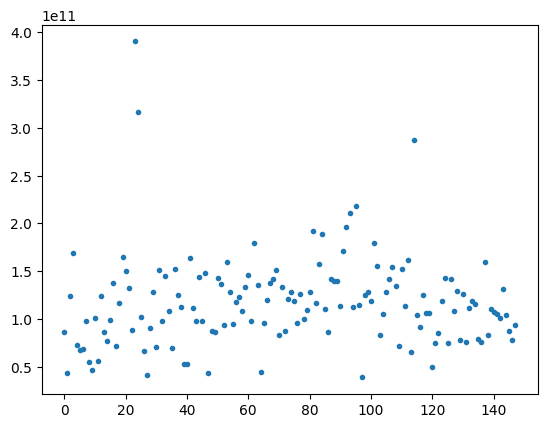

In [16]:
print((testing[6]-testing[2]).mean())
print((testing[6]-testing[2]).min())
print((testing[6]-testing[2]).max())
print((testing[6]-testing[2]).std())
print(testing[6]-testing[2])

(testing[3]-testing[2]).plot(style = '.')



# (testing[6]-testing[2]).plot(style='.')

<AxesSubplot: >

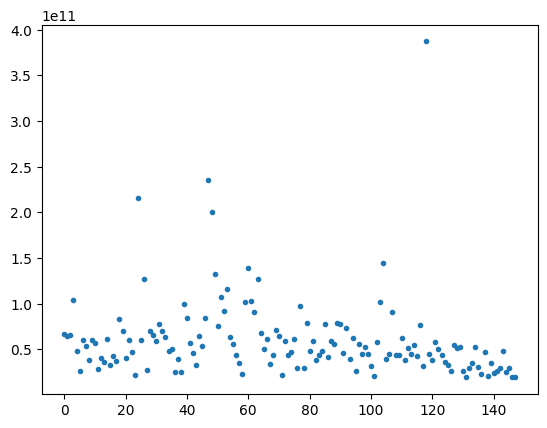

In [17]:
(testing[4]-testing[3]).plot(style = '.')


<AxesSubplot: >

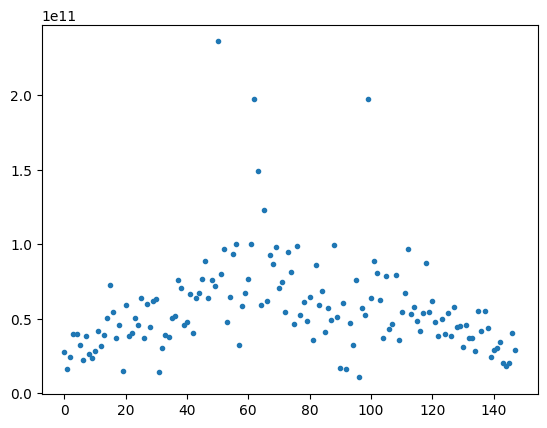

In [18]:
(testing[5]-testing[4]).plot(style = '.')


<AxesSubplot: >

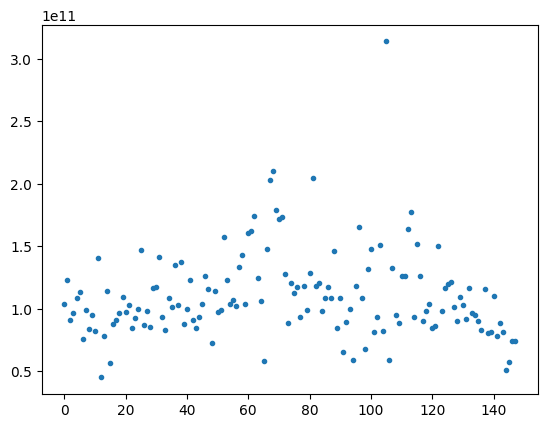

In [19]:
(testing[6]-testing[5]).plot(style = '.')

<AxesSubplot: >

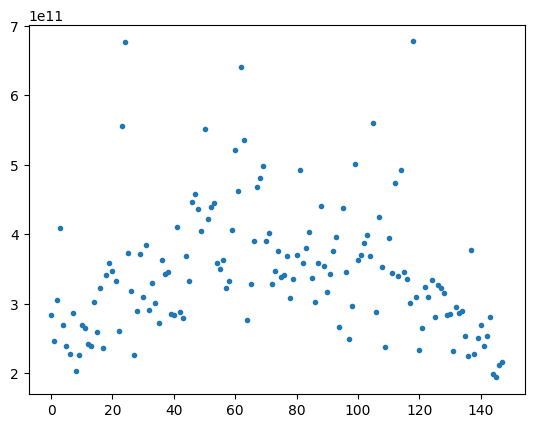

In [20]:
(testing[6]-testing[2]).plot(style = '.')

In [21]:
import json

def convert_routeid_routeno_relationship():
    today_info_file = "../data/minibus_info/" + str(datetime.datetime.today()).split()[0] + "/" + "GMB_info_" +str(datetime.datetime.today()).split()[0] + ".json"

    f = open(today_info_file)

    data = json.load(f) 

    f.close()

    routeid_routeno_df = pd.DataFrame(columns = ['route_id','route_seq','region','route_no','stops','gen_date'])

    for region in data:
        for route in region['routes']:
            for route_type in route['route_info']:
                for direction in route_type['directions']:
                    routeid_routeno_df = routeid_routeno_df.append({'route_id' : route_type['route_id'],
                                               'route_seq' : direction['route_seq'],
                                               'region' : region['Region'],
                                               'route_no' : route['route_no'],
                                               'stops' :list(range(1,len(direction['stop_info'])+1)),
                                               'gen_date' : datetime.datetime.now().date() }, ignore_index=True)
                    
    
    routeid_routeno_df.to_csv('../data/routeid_routeno_csv/routeid_routeno_{}.csv'.format(str(datetime.datetime.today()),index = False))
                              
    
    path = "../data/routeid_routeno_csv/routeid_routeno_{}.csv".format(str(datetime.datetime.today()))
    
    host = "158.132.175.131"
    username = "cassandra"
    password = "cassandra"

    query = " \" COPY hki_gmb.routeid_routeno_relationship (route_id,route_seq,region,route_no,stops,gen_date) FROM '{}' WITH DELIMITER =',' AND HEADER = TRUE; \" ".format(path)

    command = f"""cqlsh {host} -u {username} -p '{password}' -k 'hki_gmb' -e {query} """

    os.system(command)
    
